<a href="https://colab.research.google.com/github/kazuma313/everyday_coding/blob/main/StudyDeeper/ArtificialIntellegent/TensorFlow/NeuralNetwork/07_prefetch_%26_multithread.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prefetch & Multithread

menggunakan prefetch dan multithread akan mempercepat proses training pada neural network.
![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/07-prefetching-from-hands-on-ml.png)

# mixed precision training

mixed precision training merupakan penggabungan presisi dari data yang ditraining. pada hal ini biasanya float16 pada process dengan float32 pada output dan input.

mixed precision diperlukan hardware yang support pada metode ini. untuk penjelasan lebih lanjutnya berada pada [TensorFlow mixed precision guide](https://www.tensorflow.org/guide/mixed_precision)


In [27]:
import datetime
print(datetime.datetime.now())

2023-10-08 14:25:24.770051


In [28]:
!nvidia-smi

Sun Oct  8 14:25:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    26W /  70W |    389MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [29]:
import os

if not os.path.exists("helper_function.py"):
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
else:
    print("[INFO] 'helper_functions.py' already exists, skipping download.")

--2023-10-08 14:25:26--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-10-08 14:25:27 (96.3 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [30]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Import Dataset

In [31]:
import tensorflow_datasets as tfds

In [32]:
dataset_list= tfds.list_builders()
dataset_list

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'answer_equivalence',
 'arc',
 'asqa',
 'asset',
 'assin2',
 'bair_robot_pushing_small',
 'bccd',
 'beans',
 'bee_dataset',
 'beir',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'ble_wind_field',
 'blimp',
 'booksum',
 'bool_q',
 'bot_adversarial_dialogue',
 'bucc',
 'c4',
 'c4_wsrs',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cardiotox',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'cherry_blossoms',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar100_n',
 'cifar10_1',
 'cifar10_corrupted',
 'cifar10_h',
 'cifar10_n',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'clic',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coco_captions',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'conll2002',
 

In [33]:
(train_dataset, test_dataset), ds_info= tfds.load(name= "food101",
                                                  split= ["train", "validation"],
                                                  shuffle_files= True,
                                                  as_supervised= True,
                                                  with_info= True)

In [34]:
ds_info

tfds.core.DatasetInfo(
    name='food101',
    full_name='food101/2.0.0',
    description="""
    This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
    """,
    homepage='https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/',
    data_dir='/root/tensorflow_datasets/food101/2.0.0',
    file_format=tfrecord,
    download_size=4.65 GiB,
    dataset_size=4.77 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo nu

In [35]:
train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>)

In [36]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [40]:
len(train_dataset), len(test_dataset)

(75750, 25250)

In [41]:
import tensorflow as tf

In [42]:
def preprocess_image(image, label, image_shape= 224):
  """
  convert image datatype from int8 -> float32 and reshape image
  """

  image= tf.image.resize(image, [image_shape, image_shape])
  return tf.cast(image, tf.float32), label

In [43]:
# preprocessed_image= preprocess_image(image, label)

## Batch dan prepare dataset

In [44]:

train_data= train_dataset.map(map_func= preprocess_image, num_parallel_calls= tf.data.AUTOTUNE) # Melakukan paralel terhadap prosesnya
train_data= train_data.shuffle(buffer_size= 1000).batch(batch_size= 32).prefetch(buffer_size= tf.data.AUTOTUNE)

test_data= test_dataset.map(map_func= preprocess_image, num_parallel_calls= tf.data.AUTOTUNE)
test_data= test_data.batch(batch_size= 32).prefetch(buffer_size= tf.data.AUTOTUNE)


In [45]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

nice, tipe datanya telah berubah

## membuat callback

In [46]:
from helper_functions import create_tensorboard_callback

checkpoint_path= "checkpoint/cp.ckpt"

model_checkpoint= tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                     monitor= "val_accuracy",
                                                     save_best_only= True,
                                                     save_weights_only= True,
                                                     verbose= 1)

## mixed precission

In [47]:
from tensorflow.keras import mixed_precision

In [48]:
mixed_precision.set_global_policy(policy= "mixed_float16")


Jika tidak support mixed precission, makan akan muncul pesan seperti berikut:
**WARNING:tensorflow:Mixed precision compatibility check (mixed_float16): WARNING
The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once**

In [49]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Membuat model feature extraction

In [50]:
class_names= ds_info.features['label'].names


In [51]:
from tensorflow.keras import layers

In [52]:
input_shape= (224, 224, 3)

base_model= tf.keras.applications.efficientnet.EfficientNetB0(include_top= False)
base_model.trainable= False

In [53]:
inputs= layers.Input(shape= input_shape, name= "input_layer")
x= base_model(inputs, training= False)
x= layers.GlobalAveragePooling2D(name= "Global_average_pooling")(x)
x= layers.Dense(len(class_names))(x)

outputs= layers.Activation("softmax", dtype= tf.float32, name="softmax_float32")(x) # Mengembalikan presisid datatype

model= tf.keras.Model(inputs, outputs)




In [54]:
model.compile(loss= tf.keras.losses.sparse_categorical_crossentropy, # label yang digunakan tidak onehot
              optimizer= tf.keras.optimizers.Adam(),
              metrics= ["accuracy"]
              )

In [55]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 Global_average_pooling (Gl  (None, 1280)              0         
 obalAveragePooling2D)                                           
                                                                 
 dense_1 (Dense)             (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                           

In [56]:
tf.get_logger().setLevel("ERROR")

history= model.fit(train_data,
                   epochs= 5,
                   steps_per_epoch= len(train_data),
                   validation_data= test_data,
                   validation_steps= int(0.25 * len(test_data)),
                   verbose= 1,
                   callbacks= [create_tensorboard_callback("training_logs", "efficientnet"),
                               model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnet/20231008-142703
Epoch 1/5
2368/2368 [==============================] - ETA: 0s - loss: 1.7188 - accuracy: 0.5823
Epoch 1: val_accuracy improved from -inf to 0.69876, saving model to checkpoint/cp.ckpt
2368/2368 [==============================] - 199s 76ms/step - loss: 1.7188 - accuracy: 0.5823 - val_loss: 1.1362 - val_accuracy: 0.6988
Epoch 2/5
2367/2368 [============================>.] - ETA: 0s - loss: 1.2004 - accuracy: 0.6892
Epoch 2: val_accuracy improved from 0.69876 to 0.71542, saving model to checkpoint/cp.ckpt
2368/2368 [==============================] - 215s 89ms/step - loss: 1.2003 - accuracy: 0.6893 - val_loss: 1.0416 - val_accuracy: 0.7154
Epoch 3/5
2367/2368 [============================>.] - ETA: 0s - loss: 1.0533 - accuracy: 0.7251
Epoch 3: val_accuracy improved from 0.71542 to 0.72874, saving model to checkpoint/cp.ckpt
2368/2368 [==============================] - 186s 78ms/step - loss: 1.0533 - accuracy: 0.72

Terdapat beberap metode callback yang belum diterapkan, yaitu:
* EarlyStopping: Memberhentikan tahap training secara otomatis apabila performa tidak meningkat pada pada sekian epoch.
* ReduceLROnPlateau: menurunkan learning rate secara ototmatis apabila performa nya tidak meningkat pada sekian epoch.

## Evaluation

In [57]:
evaluation= model.evaluate(test_data)
evaluation

790/790 [==============================] - 55s 69ms/step - loss: 0.9759 - accuracy: 0.7333


[0.9759145975112915, 0.7332673072814941]

akurasi yang dihasilakan dengan 5 epoch menggunakan feature extracion sebesar 73.3%. Menggunakan fine-tunning biasanya dapat meningkatkan akurasinya.

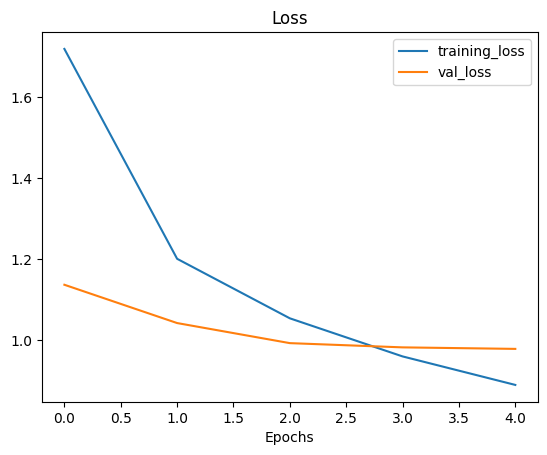

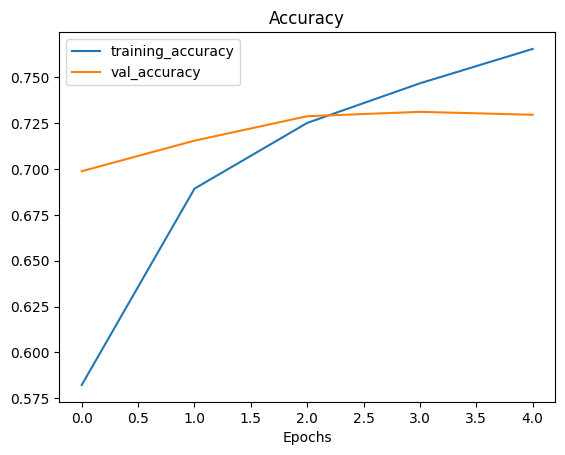

In [58]:
plot_loss_curves(history)

pada epoch ke-3, model mulai terjadi overfitting